In [1]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Define a function to load the dataset
def load_shd_data(file_path):
    with h5py.File(file_path, "r") as h5_file:
        spike_times = np.array(h5_file["spikes/times"])
        spike_units = np.array(h5_file["spikes/units"])
        labels = np.array(h5_file["labels"])
    return spike_times, spike_units, labels

# Load SHD training and test data
train_file = "data/SHD/shd_train.h5"
test_file = "data/SHD/shd_test.h5"

train_times, train_units, train_labels = load_shd_data(train_file)
test_times, test_units, test_labels = load_shd_data(test_file)

print(f"Train samples: {len(train_times)}, Test samples: {len(test_times)}")

Train samples: 8156, Test samples: 2264


In [2]:
import torch

# Define a function to convert spike events into a tensor format
def convert_to_tensor(spike_times, spike_units, num_neurons=700, time_bins=100):

    spike_tensor = np.zeros((time_bins, num_neurons), dtype=np.float32)

    # Normalize time into the `time_bins`
    if len(spike_times) > 0:
        time_idx = (spike_times / np.max(spike_times) * (time_bins - 1)).astype(int)
        spike_tensor[time_idx, spike_units] = 1  # Mark neuron firing

    return torch.tensor(spike_tensor, dtype=torch.float32)

# Example conversion
example_tensor = convert_to_tensor(train_times[0], train_units[0])
print("Converted Spike Tensor Shape:", example_tensor.shape)  # (100, 700)


Converted Spike Tensor Shape: torch.Size([100, 700])


In [3]:
class SHDDataset(Dataset):
    def __init__(self, spike_times, spike_units, labels, num_neurons=700, time_bins=100):
        self.spike_times = spike_times
        self.spike_units = spike_units
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.num_neurons = num_neurons
        self.time_bins = time_bins

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        spike_tensor = convert_to_tensor(self.spike_times[idx], self.spike_units[idx], self.num_neurons, self.time_bins)
        return spike_tensor, self.labels[idx]

# Create datasets
train_dataset = SHDDataset(train_times, train_units, train_labels)
test_dataset = SHDDataset(test_times, test_units, test_labels)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
import torch.nn as nn
"""
Increase hidden_size & Use More Layers

Helps RNN capture richer features without adding depth.
Use Dropout in the RNN

Prevents co-adaptation of neurons, reducing overfitting.
Add BatchNorm After RNN

Stabilizes activations and prevents internal covariate shift.
Apply L2 Regularization (weight_decay=1e-4)

Encourages smaller weights to improve generalization.
"""

class SHDRNN(nn.Module):
    def __init__(self, input_size=700, hidden_size=256, num_layers=2, output_size=20, dropout=0.3):
        super(SHDRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.bn = nn.BatchNorm1d(hidden_size)  # Batch Normalization
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out, _ = self.rnn(x)  # Standard RNN Layer
        out = self.fc1(out[:, -1, :])  # Use last time step output
        out = self.bn(out)  # Apply batch normalization
        out = self.relu(out)
        out = self.dropout(out)  # Dropout for regularization
        out = self.fc2(out)  # Final output layer
        return out

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SHDRNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 Regularization


In [11]:
# Store loss and accuracy for visualization
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Train model while recording loss and accuracy
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_acc = correct / total
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(train_acc)

    # Evaluate on test set
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    test_acc = correct / total
    test_losses.append(total_loss / len(test_loader))
    test_accs.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_acc:.4f}")

Epoch [1/20] - Train Loss: 3.0817, Train Acc: 0.0539 | Test Loss: 3.2986, Test Acc: 0.0495
Epoch [2/20] - Train Loss: 3.0576, Train Acc: 0.0532 | Test Loss: 3.3193, Test Acc: 0.0455
Epoch [3/20] - Train Loss: 3.0371, Train Acc: 0.0473 | Test Loss: 4.1836, Test Acc: 0.0539
Epoch [4/20] - Train Loss: 3.0007, Train Acc: 0.0533 | Test Loss: 3.2863, Test Acc: 0.0464
Epoch [5/20] - Train Loss: 2.9969, Train Acc: 0.0500 | Test Loss: 3.0611, Test Acc: 0.0539
Epoch [6/20] - Train Loss: 2.9967, Train Acc: 0.0506 | Test Loss: 3.0872, Test Acc: 0.0543
Epoch [7/20] - Train Loss: 2.9961, Train Acc: 0.0506 | Test Loss: 3.0037, Test Acc: 0.0455
Epoch [8/20] - Train Loss: 2.9960, Train Acc: 0.0497 | Test Loss: 3.0020, Test Acc: 0.0521
Epoch [9/20] - Train Loss: 2.9960, Train Acc: 0.0474 | Test Loss: 3.0193, Test Acc: 0.0543
Epoch [10/20] - Train Loss: 2.9964, Train Acc: 0.0476 | Test Loss: 3.2065, Test Acc: 0.0521
Epoch [11/20] - Train Loss: 2.9971, Train Acc: 0.0490 | Test Loss: 3.1965, Test Acc: 0.04

In [8]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.1135


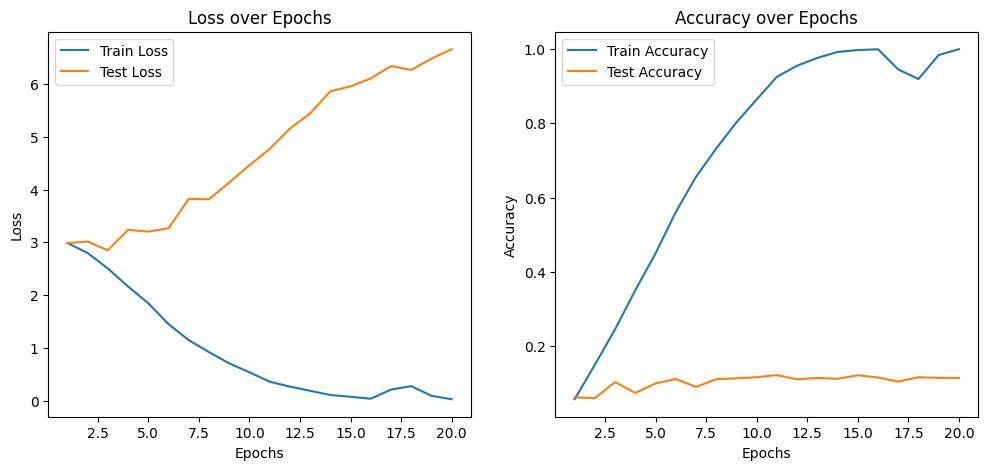

In [9]:
import matplotlib.pyplot as plt
# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accs, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.show()